In [92]:
from pathlib import Path
from pprint import pprint

import json5
import matplotlib.pyplot as plt
import pandas as pd

In [93]:
def load_logs_from_file(log_file_path):
    log_file_path = Path(log_file_path)
    if log_file_path.exists():
        with log_file_path.open(encoding="utf-8") as f:
            logs = json5.load(f)
            print("Загруженные логи:")
            pprint(logs, indent=4, width=100)
            return logs
    else:
        print(f"Файл {log_file_path} не найден.")
        return None

In [94]:
log_file_path = "./logs/method_logs.json"
logs = load_logs_from_file(log_file_path)

Загруженные логи:
[   {   'method_args': {   'init': 'svd',
                           'n_iter_max': 100,
                           'random_state': 42,
                           'rank': [220, 360, 202, 3],
                           'svd': 'truncated_svd'},
        'method_name': 'TensorLy_Tucker_pytorch_truncated_svd_svd',
        'qualitative_metrics': {   'Decomposition method': 'Tucker',
                                   'Language': 'Python',
                                   'Library': 'TensorLy',
                                   'Platform': 'CPU, GPU',
                                   'Tensor type': 'Dense',
                                   'TensorLy backend': 'pytorch'},
        'quantitative_metrics': {   'compression_ratio': 50.27837471247125,
                                    'duration': {   'max': 7.773032903671265,
                                                    'mean': 7.773032903671265,
                                                    'min': 7.773032903

In [95]:
# Собираем данные для метрик с min, max и mean
log_data = []

for log in logs:
    data_entry = {
        "method_name": log["method_name"],
        "gpu_allocated_mem_mean": log["quantitative_metrics"]["gpu_allocated_mem_usage"]["mean"],
        "gpu_allocated_mem_min": log["quantitative_metrics"]["gpu_allocated_mem_usage"]["min"],
        "gpu_allocated_mem_max": log["quantitative_metrics"]["gpu_allocated_mem_usage"]["max"],
        "gpu_cached_mem_mean": log["quantitative_metrics"]["gpu_cached_mem_usages"]["mean"],
        "gpu_cached_mem_min": log["quantitative_metrics"]["gpu_cached_mem_usages"]["min"],
        "gpu_cached_mem_max": log["quantitative_metrics"]["gpu_cached_mem_usages"]["max"],
        "ram_mem_usage_mean": log["quantitative_metrics"]["ram_mem_usage"]["mean"],
        "ram_mem_usage_min": log["quantitative_metrics"]["ram_mem_usage"]["min"],
        "ram_mem_usage_max": log["quantitative_metrics"]["ram_mem_usage"]["max"],
        "gpu_allocated_mem": log["quantitative_metrics"]["gpu_allocated_mem_usage"]["mean"],
        "gpu_cached_mem": log["quantitative_metrics"]["gpu_cached_mem_usages"]["mean"],
        "ram_mem_usage": log["quantitative_metrics"]["ram_mem_usage"]["mean"],
        "duration": log["quantitative_metrics"]["duration"]["mean"],
        "duration_mean": log["quantitative_metrics"]["duration"]["mean"],
        "duration_min": log["quantitative_metrics"]["duration"]["min"],
        "duration_max": log["quantitative_metrics"]["duration"]["max"],
        "frobenius_error": log["quantitative_metrics"]["frobenius_error"],
        "compression_ratio": log["quantitative_metrics"]["compression_ratio"],
        "decomposition_method": log["qualitative_metrics"]["Decomposition method"],
        "language": log["qualitative_metrics"]["Language"],
        "library": log["qualitative_metrics"]["Library"],
        "platform": log["qualitative_metrics"]["Platform"],
        "tensor_type": log["qualitative_metrics"]["Tensor type"],
    }
    log_data.append(data_entry)

df_logs = pd.DataFrame(log_data)

In [96]:
methods = df_logs["method_name"].unique()

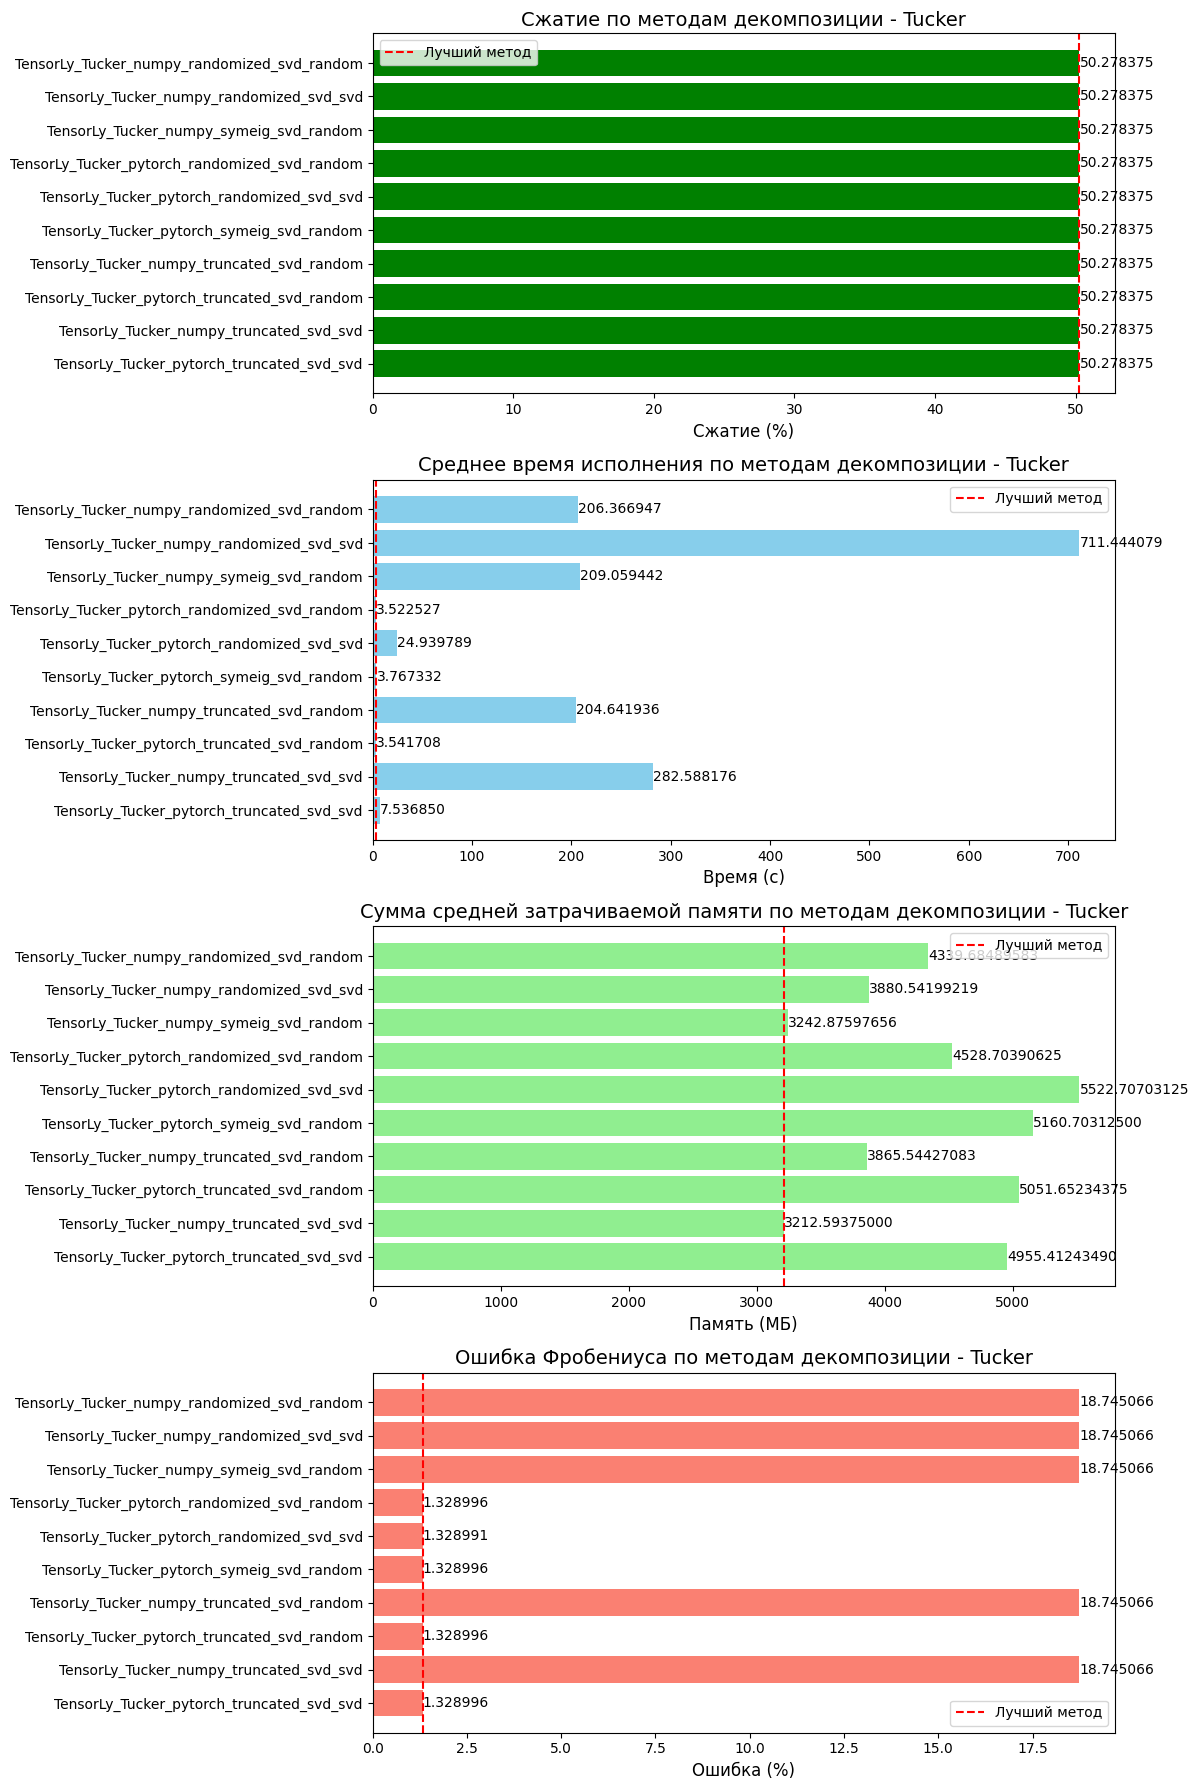

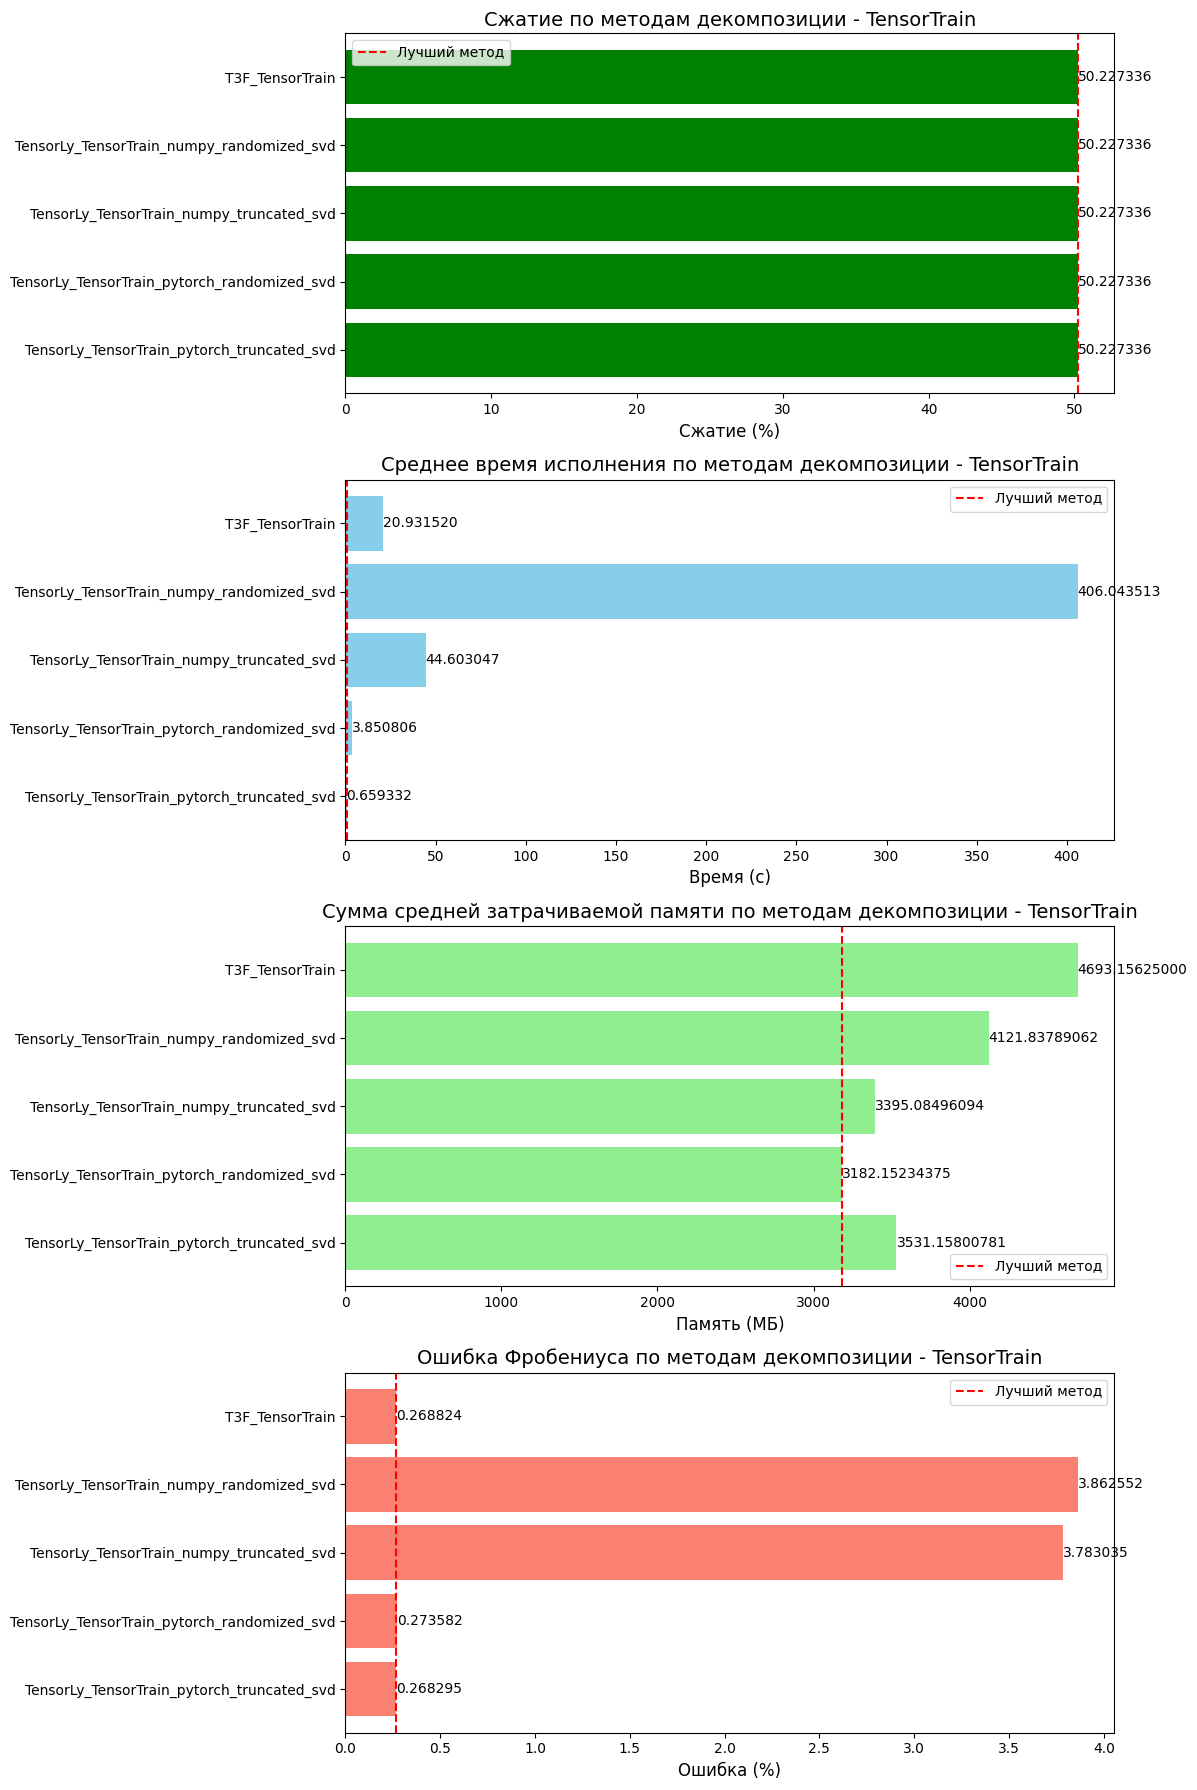

In [97]:
decomposition_methods = df_logs["decomposition_method"].unique()
analysis_results = {}

for decomposition_method in decomposition_methods:
    method_data = df_logs[df_logs["decomposition_method"] == decomposition_method]
    methods = method_data["method_name"].unique()
    analysis_data = []

    for method in methods:
        method_specific_data = method_data[method_data["method_name"] == method]

        compression_ratio = method_specific_data["compression_ratio"].mean()
        average_time = method_specific_data["duration"].mean()
        total_memory = method_specific_data["ram_mem_usage"].mean() + method_specific_data["gpu_cached_mem"].mean()
        frobenius_error = method_specific_data["frobenius_error"].mean()

        analysis_data.append(
            {
                "method_name": method,
                "average_time": average_time,
                "total_memory": total_memory,
                "frobenius_error": frobenius_error,
                "compression_ratio": compression_ratio,
            }
        )

    analysis_df = pd.DataFrame(analysis_data)

    best_compression_ratio_method = analysis_df.loc[analysis_df["compression_ratio"].idxmin()]
    best_time_method = analysis_df.loc[analysis_df["average_time"].idxmin()]
    best_memory_method = analysis_df.loc[analysis_df["total_memory"].idxmin()]
    best_error_method = analysis_df.loc[analysis_df["frobenius_error"].idxmin()]

    analysis_results[decomposition_method] = {
        "best_time_method": best_time_method,
        "best_memory_method": best_memory_method,
        "best_error_method": best_error_method,
    }

    fig, axes = plt.subplots(4, 1, figsize=(12, 18))

    axes[0].barh(analysis_df["method_name"], analysis_df["compression_ratio"], color="green")
    axes[0].set_title(f"Сжатие по методам декомпозиции - {decomposition_method}", fontsize=14)
    axes[0].set_xlabel("Сжатие (%)", fontsize=12)

    axes[0].axvline(x=best_compression_ratio_method["compression_ratio"], color="red", linestyle="--", label="Лучший метод")
    axes[0].legend()
    for i in range(len(analysis_df)):
        axes[0].text(analysis_df["compression_ratio"].iloc[i], i, f'{analysis_df["compression_ratio"].iloc[i]:.6f}', va="center")

    axes[1].barh(analysis_df["method_name"], analysis_df["average_time"], color="skyblue")
    axes[1].set_title(f"Среднее время исполнения по методам декомпозиции - {decomposition_method}", fontsize=14)
    axes[1].set_xlabel("Время (с)", fontsize=12)

    axes[1].axvline(x=best_time_method["average_time"], color="red", linestyle="--", label="Лучший метод")
    axes[1].legend()
    for i in range(len(analysis_df)):
        axes[1].text(analysis_df["average_time"].iloc[i], i, f'{analysis_df["average_time"].iloc[i]:.6f}', va="center")

    axes[2].barh(analysis_df["method_name"], analysis_df["total_memory"], color="lightgreen")
    axes[2].set_title(f"Сумма средней затрачиваемой памяти по методам декомпозиции - {decomposition_method}", fontsize=14)
    axes[2].set_xlabel("Память (МБ)", fontsize=12)

    axes[2].axvline(x=best_memory_method["total_memory"], color="red", linestyle="--", label="Лучший метод")
    axes[2].legend()
    for i in range(len(analysis_df)):
        axes[2].text(analysis_df["total_memory"].iloc[i], i, f'{analysis_df["total_memory"].iloc[i]:.8f}', va="center")

    axes[3].barh(analysis_df["method_name"], analysis_df["frobenius_error"], color="salmon")
    axes[3].set_title(f"Ошибка Фробениуса по методам декомпозиции - {decomposition_method}", fontsize=14)
    axes[3].set_xlabel("Ошибка (%)", fontsize=12)

    axes[3].axvline(x=best_error_method["frobenius_error"], color="red", linestyle="--", label="Лучший метод")
    axes[3].legend()
    for i in range(len(analysis_df)):
        axes[3].text(analysis_df["frobenius_error"].iloc[i], i, f'{analysis_df["frobenius_error"].iloc[i]:.6f}', va="center")

    plt.tight_layout()
    plt.show()

In [98]:
for decomposition_method, results in analysis_results.items():
    print(f"Лучшие методы для {decomposition_method}:")
    print("По среднему времени исполнения:")
    print(results["best_time_method"])
    print("\nПо сумме средней затрачиваемой памяти:")
    print(results["best_memory_method"])
    print("\nПо ошибке Фробениуса:")
    print(results["best_error_method"])
    print("\n")
    print("=" * 50)
    print("\n")

best_methods = (
    [result["best_time_method"]["method_name"] for result in analysis_results.values()]
    + [result["best_memory_method"]["method_name"] for result in analysis_results.values()]
    + [result["best_error_method"]["method_name"] for result in analysis_results.values()]
)

best_logs = df_logs[df_logs["method_name"].isin(best_methods)]

Лучшие методы для Tucker:
По среднему времени исполнения:
method_name          TensorLy_Tucker_pytorch_randomized_svd_random
average_time                                              3.522527
total_memory                                           4528.703906
frobenius_error                                           1.328996
compression_ratio                                        50.278375
Name: 6, dtype: object

По сумме средней затрачиваемой памяти:
method_name          TensorLy_Tucker_numpy_truncated_svd_svd
average_time                                      282.588176
total_memory                                      3212.59375
frobenius_error                                    18.745066
compression_ratio                                  50.278375
Name: 1, dtype: object

По ошибке Фробениуса:
method_name          TensorLy_Tucker_pytorch_randomized_svd_svd
average_time                                          24.939789
total_memory                                        5522.707031
f

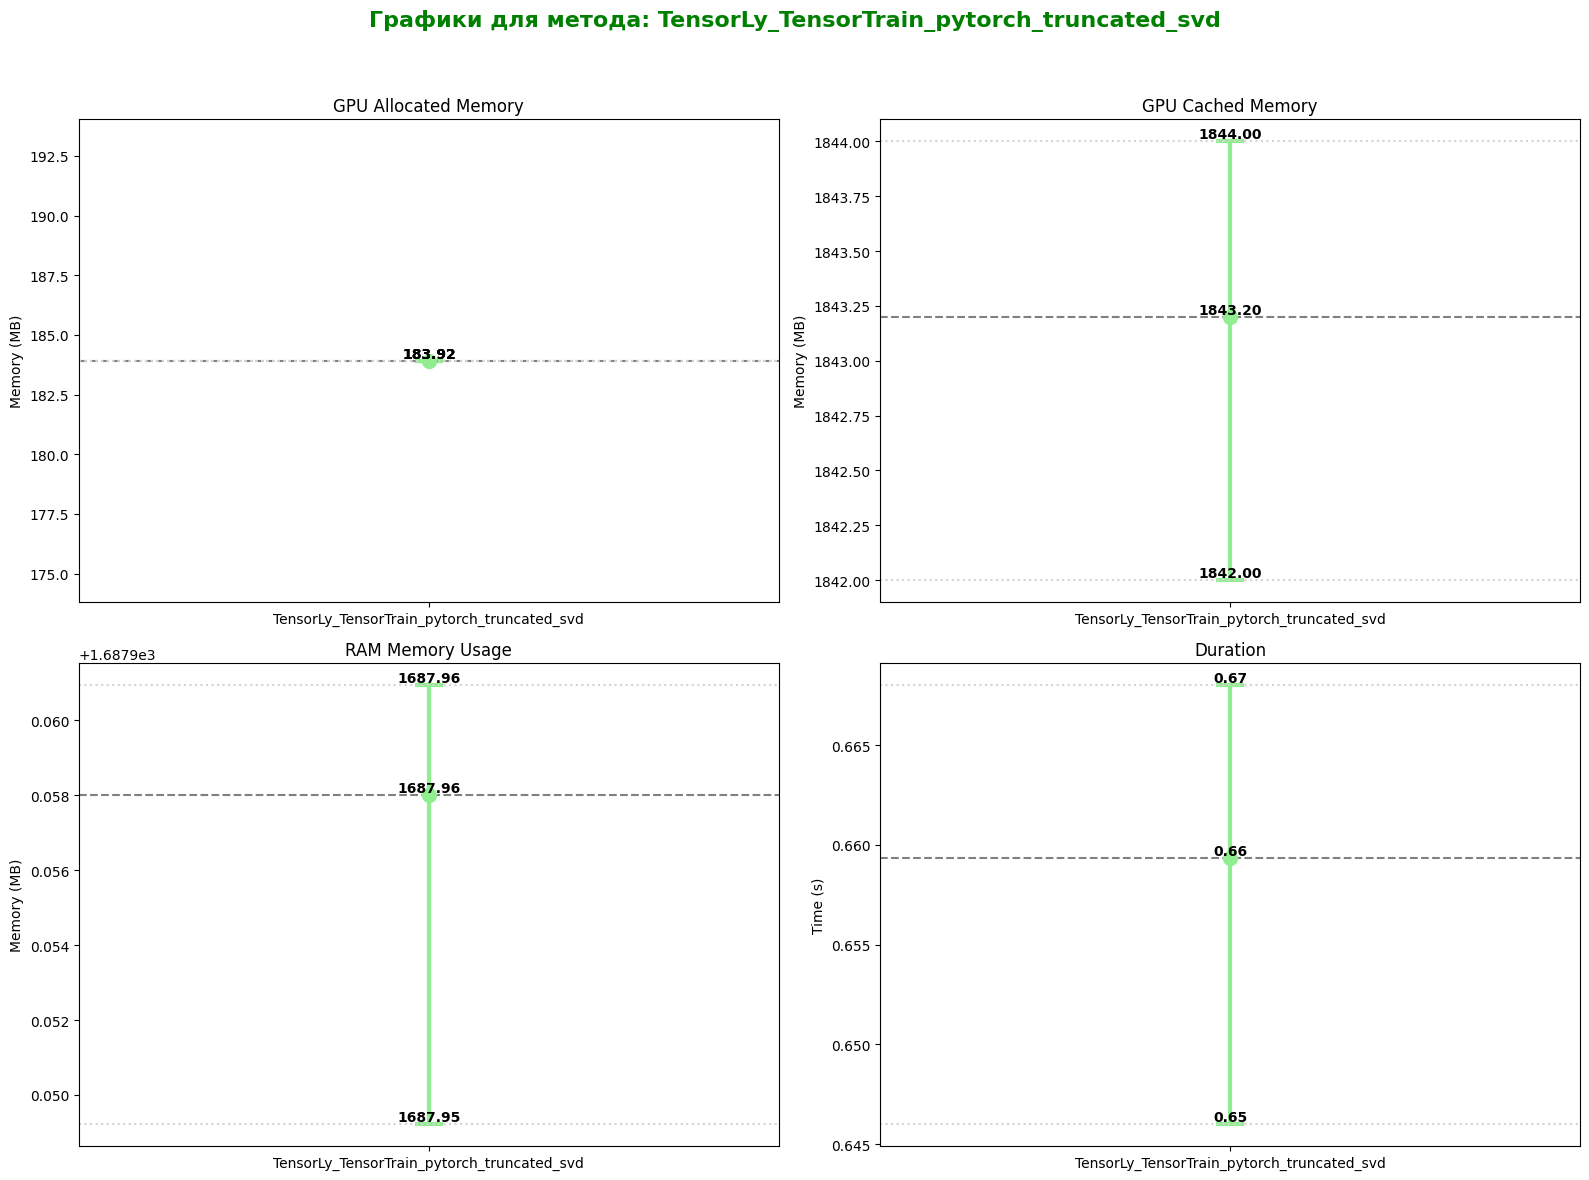

================================================== Конец графиков для метода: TensorLy_TensorTrain_pytorch_truncated_svd ==================================================



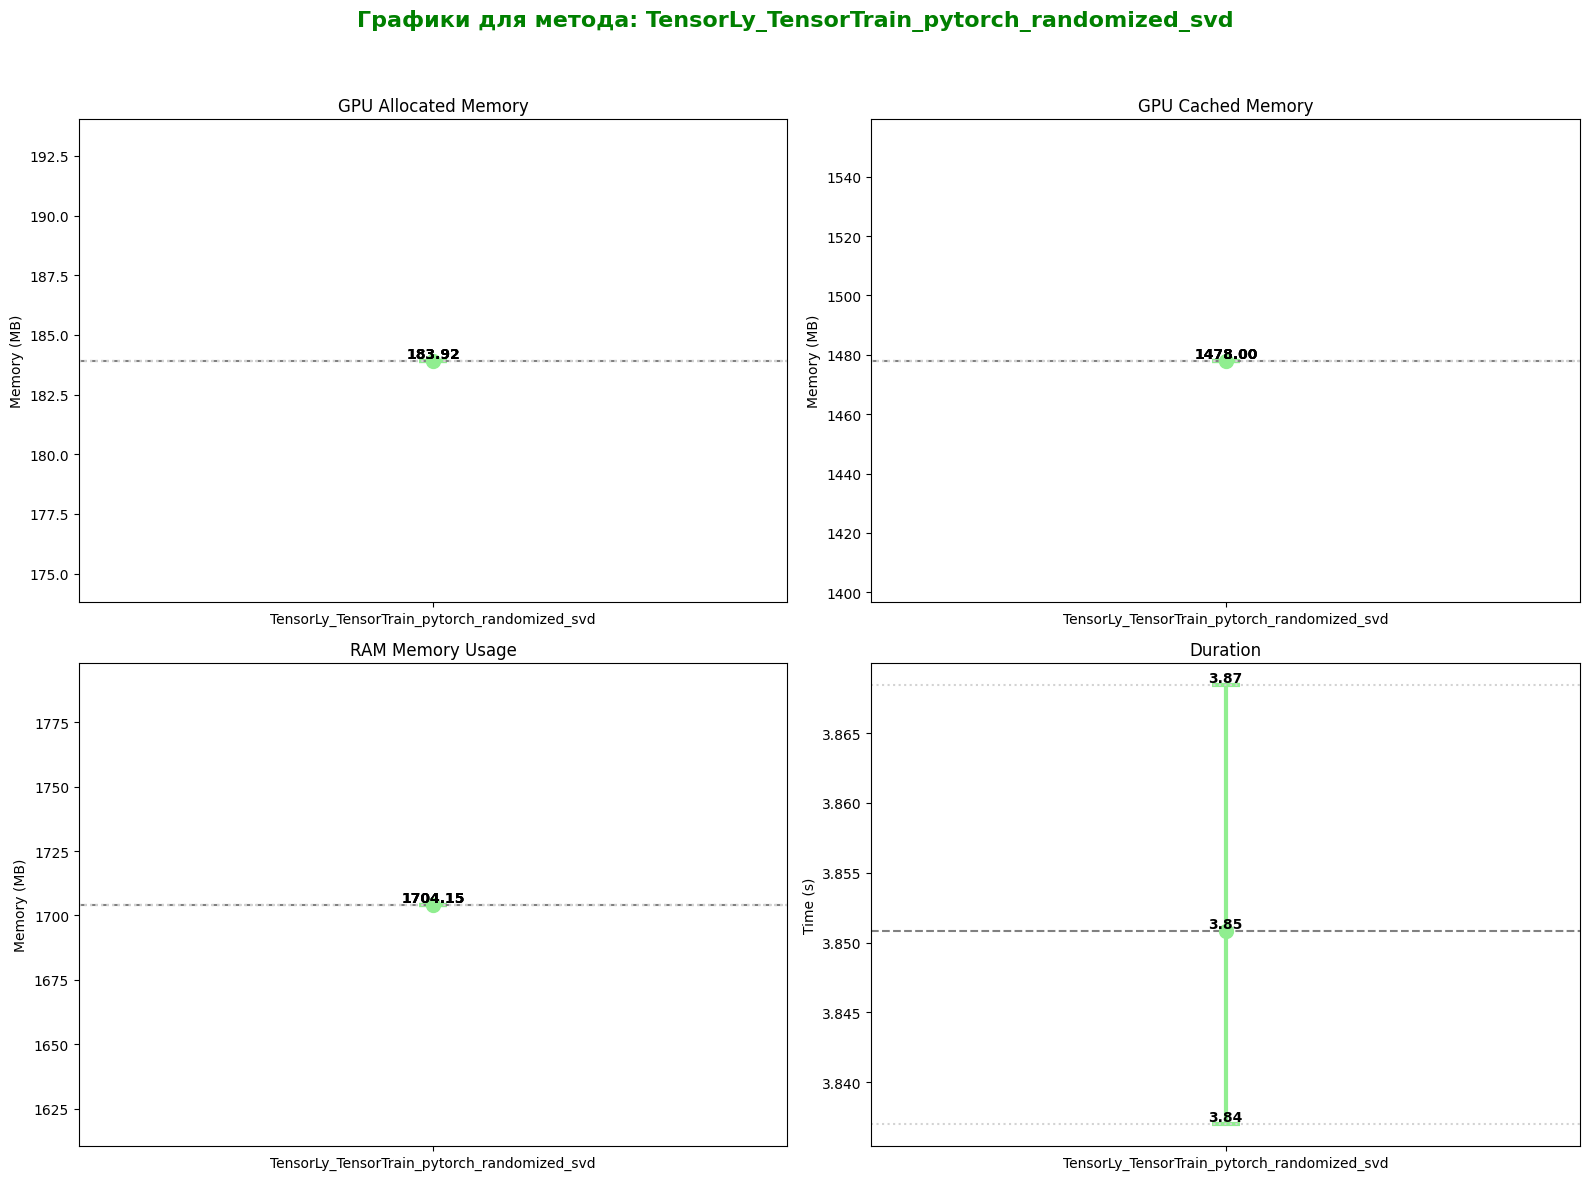

================================================== Конец графиков для метода: TensorLy_TensorTrain_pytorch_randomized_svd ==================================================



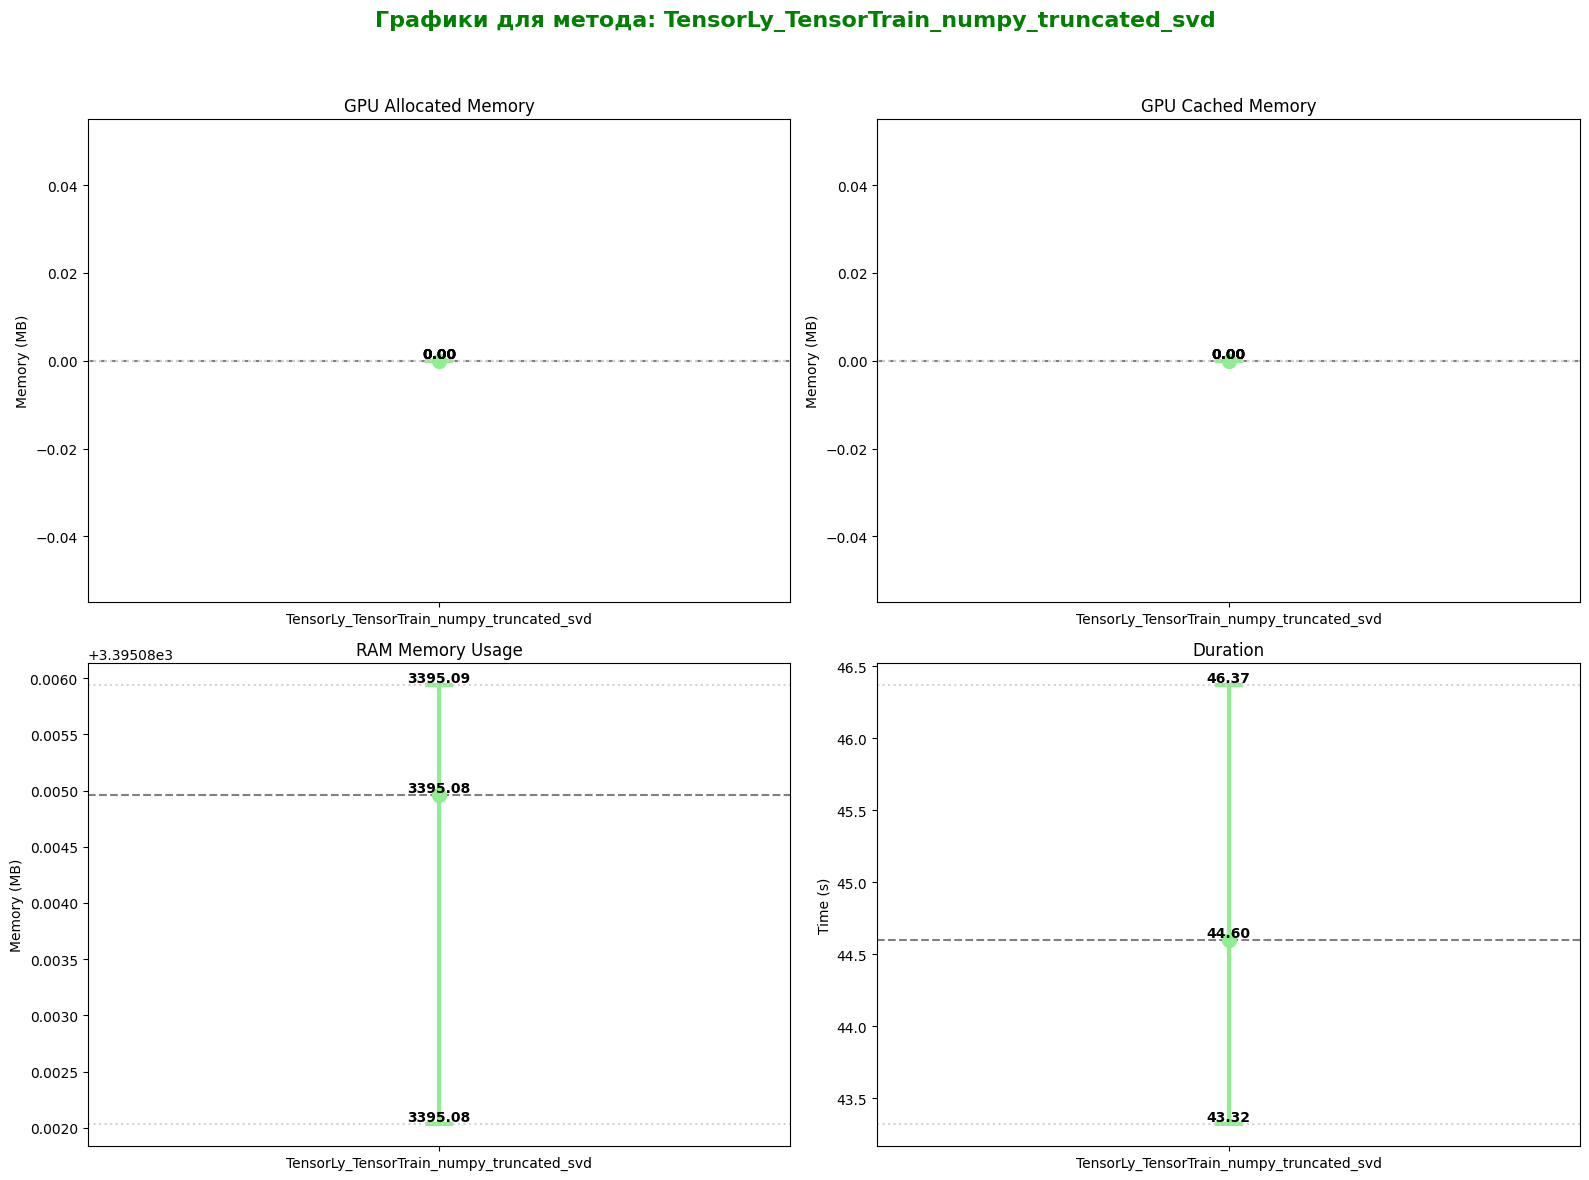

================================================== Конец графиков для метода: TensorLy_TensorTrain_numpy_truncated_svd ==================================================



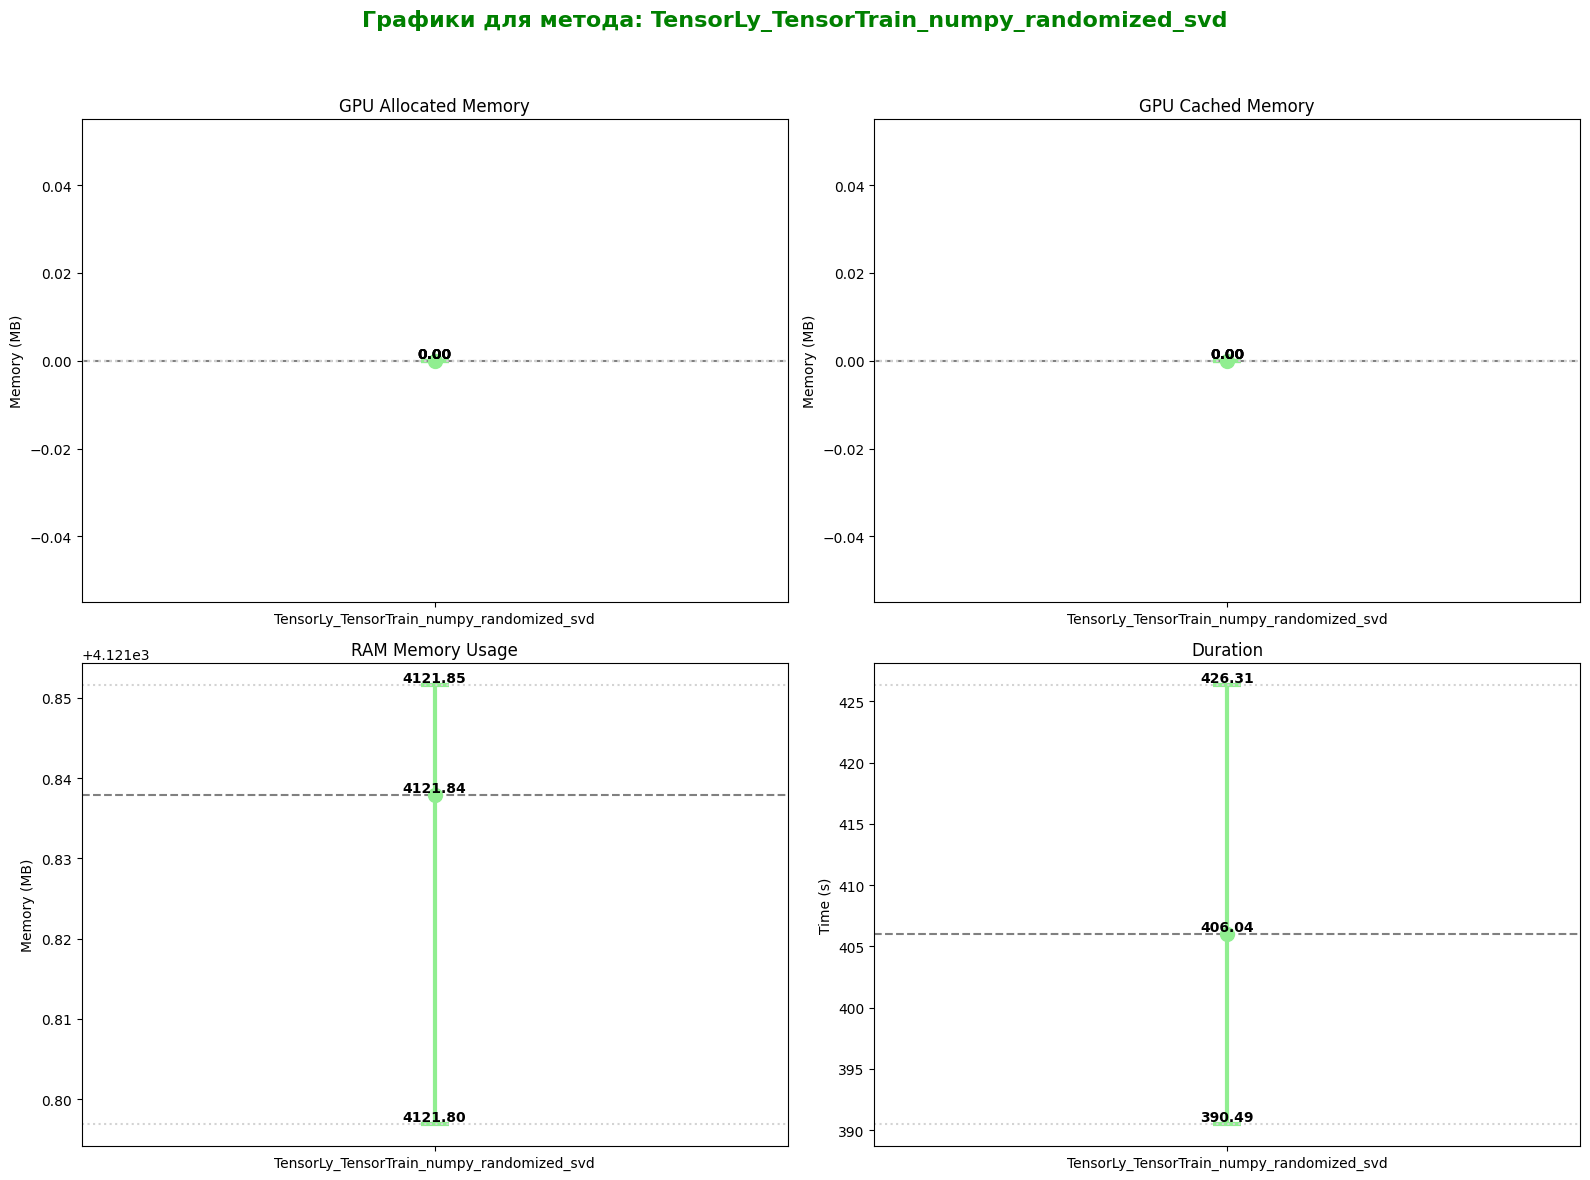

================================================== Конец графиков для метода: TensorLy_TensorTrain_numpy_randomized_svd ==================================================



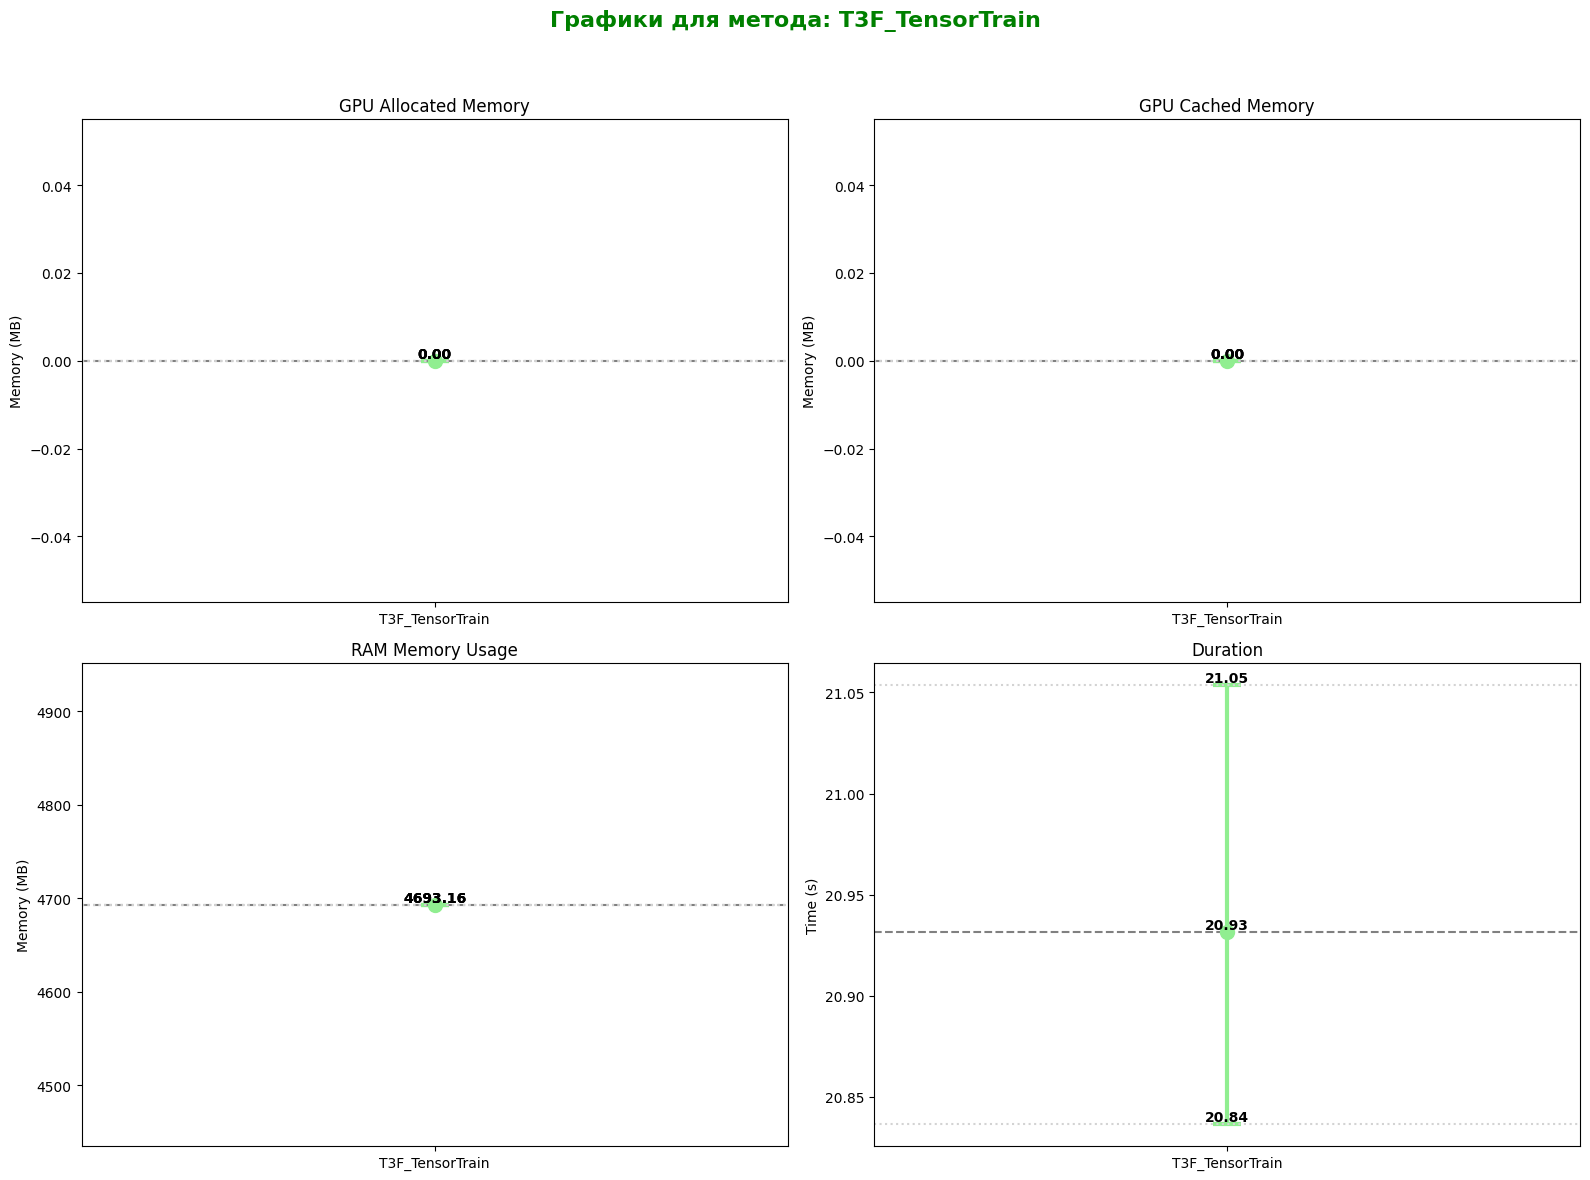

================================================== Конец графиков для метода: T3F_TensorTrain ==================================================



In [100]:
for method in methods:
    method_data = df_logs[df_logs["method_name"] == method]

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f"Графики для метода: {method}", fontsize=16, fontweight="bold", color="green")

    def plot_error_bars(method, ax, data_mean, data_min, data_max, title, ylabel):
        ax.errorbar(
            [0],
            [data_mean],
            yerr=[[data_mean - data_min], [data_max - data_mean]],
            fmt="o",
            markersize=10,
            capsize=10,
            capthick=3,
            elinewidth=3,
            color="lightgreen",
        )
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xticks([0])
        ax.set_xticklabels([method])

        for val, _label in zip([data_mean, data_min, data_max], ["Mean", "Min", "Max"], strict=False):
            ax.text(0, val, f"{val:.2f}", ha="center", va="bottom", fontsize=10, fontweight="bold")

        ax.axhline(y=data_mean, color="grey", linestyle="--")
        ax.axhline(y=data_min, color="lightgrey", linestyle=":")
        ax.axhline(y=data_max, color="lightgrey", linestyle=":")

    plot_error_bars(
        method,
        axes[0, 0],
        method_data["gpu_allocated_mem_mean"].to_numpy()[0],
        method_data["gpu_allocated_mem_min"].to_numpy()[0],
        method_data["gpu_allocated_mem_max"].to_numpy()[0],
        "GPU Allocated Memory",
        "Memory (MB)",
    )

    plot_error_bars(
        method,
        axes[0, 1],
        method_data["gpu_cached_mem_mean"].to_numpy()[0],
        method_data["gpu_cached_mem_min"].to_numpy()[0],
        method_data["gpu_cached_mem_max"].to_numpy()[0],
        "GPU Cached Memory",
        "Memory (MB)",
    )

    plot_error_bars(
        method,
        axes[1, 0],
        method_data["ram_mem_usage_mean"].to_numpy()[0],
        method_data["ram_mem_usage_min"].to_numpy()[0],
        method_data["ram_mem_usage_max"].to_numpy()[0],
        "RAM Memory Usage",
        "Memory (MB)",
    )

    plot_error_bars(
        method,
        axes[1, 1],
        method_data["duration_mean"].to_numpy()[0],
        method_data["duration_min"].to_numpy()[0],
        method_data["duration_max"].to_numpy()[0],
        "Duration",
        "Time (s)",
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    print(f"{'='*50} Конец графиков для метода: {method} {'='*50}\n")